Clusters found: 7
Cluster to category mapping:
{0: 'Ekonomi', 1: 'Doğal Afetler', 2: 'Siyasi', 3: 'Savaşlar', 4: 'Kültürel', 5: 'Bilimsel', 6: 'Savaşlar'}


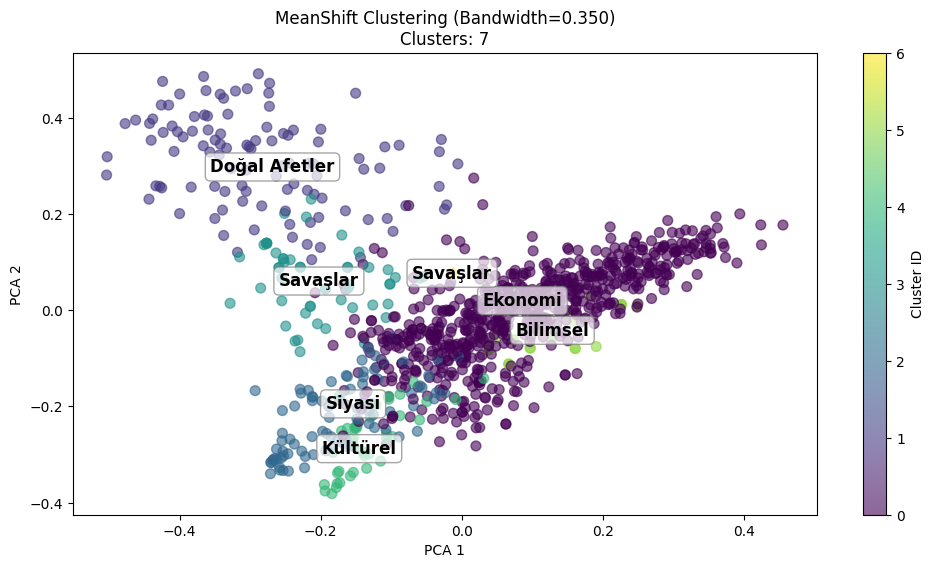

✅ Mean Shift benchmark verisi başarıyla eklendi.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
import json

def save_to_benchmark(X, labels, accuracy=None):
    sil_score = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    davies_score = davies_bouldin_score(X, labels)

    benchmark_entry = {
        "vectorizer": "TF-IDF",
        "cluster_model": "MeanShift",
        "accuracy": float(round(accuracy, 4)) if accuracy is not None else "N/A",
        "silhouette": float(round(sil_score, 4)),
        "calinski_harabasz": float(round(calinski_score, 4)),
        "davies_bouldin": float(round(davies_score, 4))
    }

    benchmark_path = "../../Outputs/benchmark.json"
    if os.path.exists(benchmark_path):
        with open(benchmark_path, "r", encoding="utf-8") as f:
            try:
                benchmark_data = json.load(f)
            except json.JSONDecodeError:
                benchmark_data = []
    else:
        benchmark_data = []

    benchmark_data.append(benchmark_entry)

    with open(benchmark_path, "w", encoding="utf-8") as f:
        json.dump(benchmark_data, f, indent=4, ensure_ascii=False)

    print(f"✅ Mean Shift benchmark verisi başarıyla eklendi.")

# ----------- Ana kod --------------

# Veriyi oku
df = pd.read_csv("../../Datas/data.csv").head(1000)

# TF-IDF ile metni sayısal hale çevir
vectorizer = TfidfVectorizer(max_features=300)
X = vectorizer.fit_transform(df['content']).toarray().astype(np.float32)

# PCA ile boyut indir (10 boyut)
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

# Bandwidth tahini
bandwidth = 0.35
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_reduced)

print(f"Clusters found: {len(np.unique(ms.labels_))}")

# Her cluster için en yaygın category'yi bul
cluster_labels = ms.labels_
df['cluster'] = cluster_labels

cluster_to_category = {}
for cluster_id in np.unique(cluster_labels):
    categories_in_cluster = df[df['cluster'] == cluster_id]['category']
    most_common_cat = categories_in_cluster.mode()[0]
    cluster_to_category[cluster_id] = most_common_cat

df['cluster_category'] = df['cluster'].map(cluster_to_category)

print("Cluster to category mapping:")
print(cluster_to_category)

# Sonuçları 2D PCA ile görselleştir
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_reduced)
centroids_2d = pca_2d.transform(ms.cluster_centers_)

plt.figure(figsize=(12,6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)

for i, centroid in enumerate(centroids_2d):
    plt.text(centroid[0], centroid[1], cluster_to_category[i],
             fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'),
             ha='center', va='center')

plt.title(f"MeanShift Clustering (Bandwidth={bandwidth:.3f})\nClusters: {len(ms.cluster_centers_)}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")

plt.savefig("../../Outputs/Graphs/mean_shift_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# Benchmark kaydı yap
save_to_benchmark(X_reduced, cluster_labels)
